In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [6]:
data = pd.read_excel(r"C:\Users\arshi\Desktop\DS_projects\Price_Forecasting_CME\202103251401_CME_Data.xlsx", sheet_name='SEP-21')
data.columns = ['Date', 'Time', 'Price', 'Volume', 'Status']

# Display the first few rows to understand its structure
data.head()

,Date,Time,Price,Volume,Status
0,03/24/2021,19:03:49,4899.0,0.0,Open
1,03/24/2021,21:39:47,4902.0,1.0,-
2,03/24/2021,21:39:47,4901.0,1.0,-
3,03/24/2021,21:39:47,4900.0,1.0,-
4,03/24/2021,22:00:37,4909.0,2.0,-


In [7]:
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data[['Datetime', 'Price','Volume']]

# Sort data by Datetime (important for time series)
data = data.sort_values(by='Datetime')
data.reset_index(drop=True,inplace = True)
data = data.iloc[:-1]
print(data.shape)

(1011, 3)


In [8]:
data.head()

,Datetime,Price,Volume
0,2021-03-24 01:17:12,4911.0,3.0
1,2021-03-24 01:17:22,4912.0,1.0
2,2021-03-24 01:17:22,4912.0,1.0
3,2021-03-24 01:18:28,4913.0,1.0
4,2021-03-24 01:20:22,4915.0,1.0


In [9]:
data.tail()

,Datetime,Price,Volume
1006,2021-03-24 21:39:47,4901.0,1.0
1007,2021-03-24 21:39:47,4902.0,1.0
1008,2021-03-24 22:00:37,4909.0,2.0
1009,2021-03-24 22:02:21,4905.0,2.0
1010,2021-03-24 23:05:30,4914.0,1.0


## Stationary Tests

In [10]:
data.set_index('Datetime', inplace=True)
data_resampled = np.round(data['Price'].resample('min').mean())
data_resampled.interpolate(method='linear',inplace = True)
data_resampled.shape

(1309,)

In [11]:
data_resampled.head()

Datetime
2021-03-24 01:17:00    4912.0
2021-03-24 01:18:00    4913.0
2021-03-24 01:19:00    4914.0
2021-03-24 01:20:00    4915.0
2021-03-24 01:21:00    4915.0
Freq: T, Name: Price, dtype: float64

In [12]:
adf_test = adfuller(data_resampled.dropna())  # Drop NA values for the test
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# data_resampled_stationary = data_resampled
if adf_test[1] > 0.05:
    data_resampled_stationary = data_resampled.diff().dropna()  # First-order differencing
else:
    data_resampled_stationary = data_resampled

ADF Statistic: -1.478743477419643
p-value: 0.5439992109480887


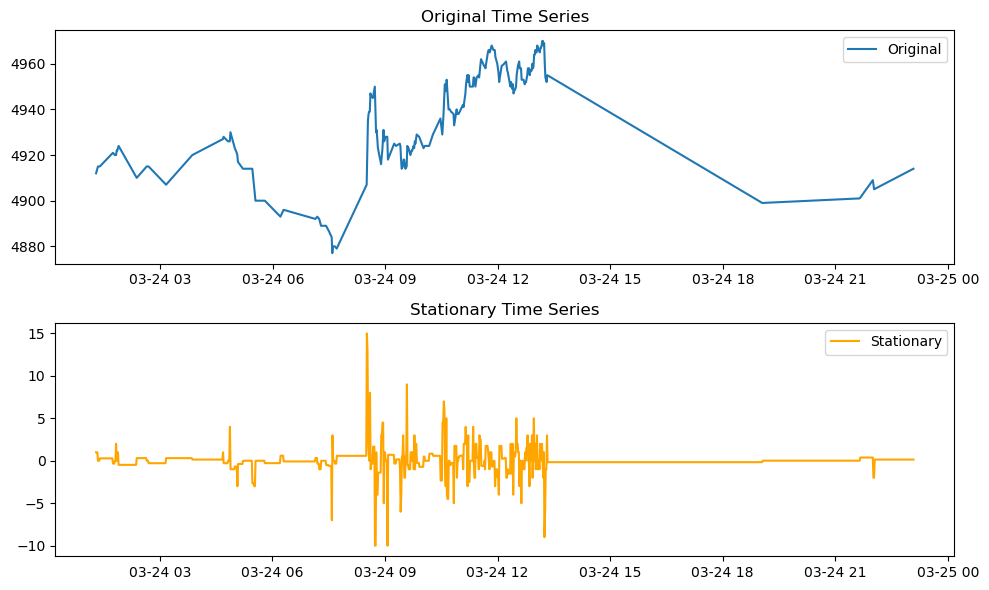

In [13]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(data_resampled, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_resampled_stationary, label='Stationary', color='orange')
plt.title('Stationary Time Series')
plt.legend()
plt.tight_layout()
plt.show()



In [14]:
# Step 5: Train-Test Split
train_size = int(0.8 * len(data_resampled_stationary))
train_data = data_resampled_stationary[:train_size]
test_data = data_resampled_stationary[train_size:]

# Display train and test split
print(f"Train Data: {train_data.shape}")
print(f"Test Data: {test_data.shape}")

Train Data: (1046,)
Test Data: (262,)


## ACF & PACF

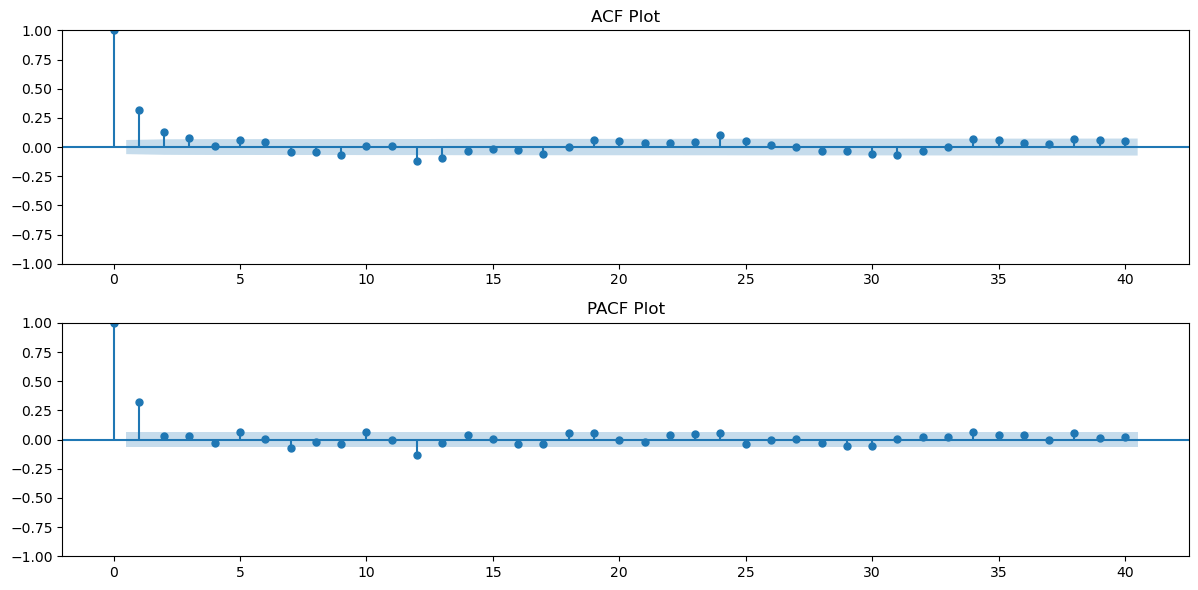

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(train_data, ax=plt.gca(), lags=40)
plt.title('ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(train_data, ax=plt.gca(), lags=40)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

## ARIMA

In [16]:
p, d, q = 1, 2, 2  # Replace with values identified from ACF/PACF
arima_model = ARIMA(train_data, order=(p, d, q))
arima_result = arima_model.fit()
print(arima_result.summary())


c:\Users\arshi\anaconda3\envs\price_forecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1046
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1804.033
Date:                Wed, 27 Nov 2024   AIC                           3616.066
Time:                        16:50:01   BIC                           3635.869
Sample:                    03-24-2021   HQIC                          3623.576
                         - 03-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3205      0.010     31.420      0.000       0.300       0.340
ma.L1         -1.9930      0.031    -65.253      0.000      -2.053      -1.933
ma.L2          0.9930      0.030     32.790      0.0

In [17]:
arima_forecast = arima_result.forecast(steps=len(test_data))
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print(f"ARIMA RMSE: {arima_rmse}")


ARIMA RMSE: 0.33540165208298145


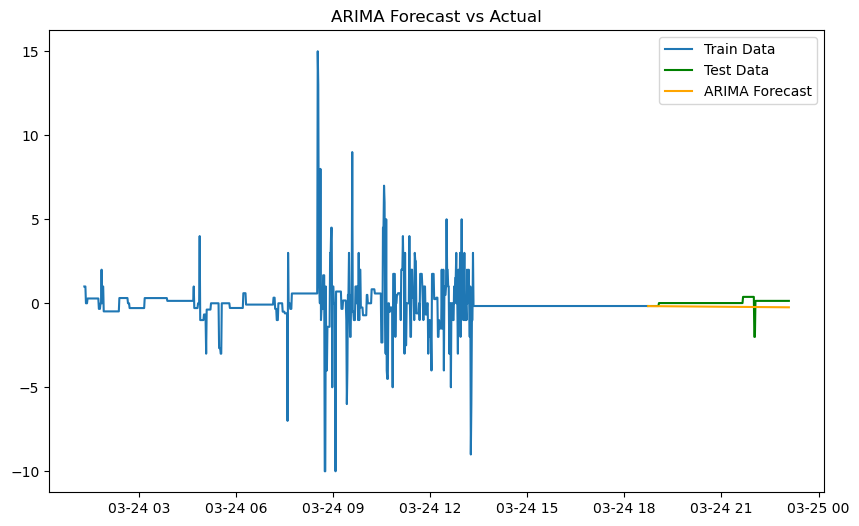

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data',color='green')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

## SARIMA

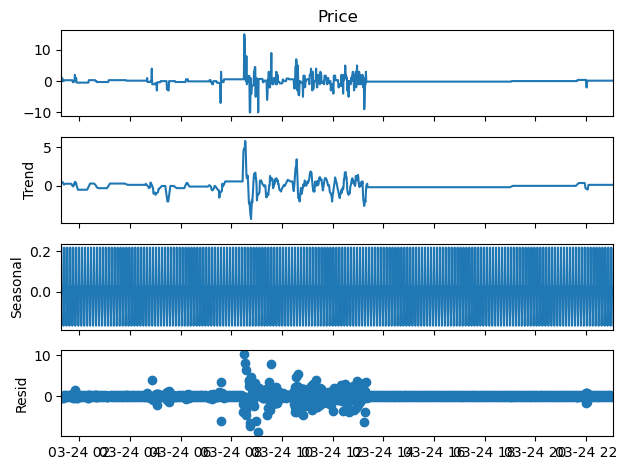

In [19]:
seasonal_decompose(data_resampled_stationary.dropna(), model='additive', period=7).plot()
plt.show()

In [20]:
P, D, Q, s = 3, 2, 1, 24  # Replace with identified seasonal parameters
sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()
print(sarima_result.summary())


c:\Users\arshi\anaconda3\envs\price_forecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\arshi\anaconda3\envs\price_forecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                 1046
Model:             SARIMAX(1, 2, 2)x(3, 2, [1], 24)   Log Likelihood               -1927.013
Date:                              Wed, 27 Nov 2024   AIC                           3870.026
Time:                                      17:04:35   BIC                           3909.256
Sample:                                  03-24-2021   HQIC                          3884.939
                                       - 03-24-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3146      0.014     22.603      0.000       0.287       0.342
ma.L1         -1.98

In [21]:
sarima_forecast = sarima_result.forecast(steps=len(test_data))
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
print(f"SARIMA RMSE: {sarima_rmse}")

SARIMA RMSE: 0.5382883315785867


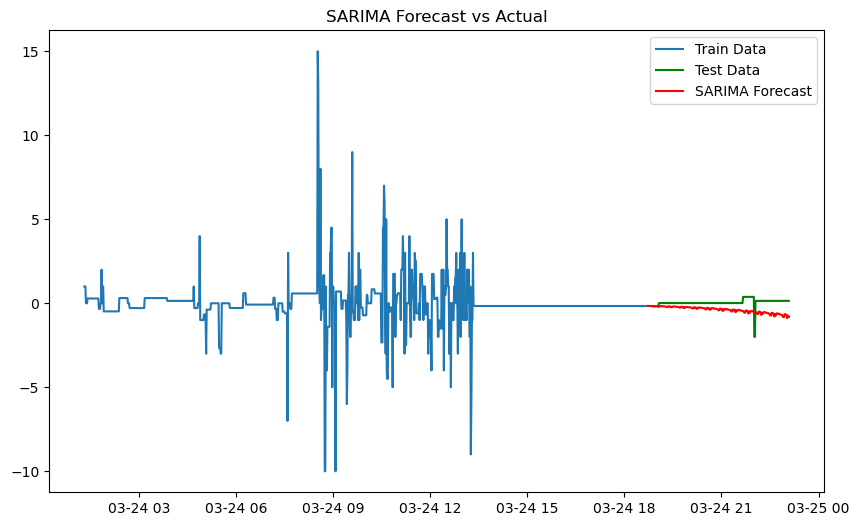

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data',color='green')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

## LSTM

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
data_lstm = data_resampled.dropna().values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_lstm)
data_scaled

array([[0.37634409],
       [0.38709677],
       [0.39784946],
       ...,
       [0.39477727],
       [0.39631336],
       [0.39784946]])

In [25]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 50  # Number of lags in each sequence
X, y = create_sequences(data_scaled, sequence_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

# train test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
model1 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])
model1.compile(optimizer='adam', loss='mean_squared_error')
history = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
32/32 [==============================] - 5s 61ms/step - loss: 0.0414 - val_loss: 0.0071
Epoch 2/20
32/32 [==============================] - 1s 33ms/step - loss: 0.0073 - val_loss: 1.6007e-04
Epoch 3/20
32/32 [==============================] - 1s 31ms/step - loss: 0.0053 - val_loss: 1.0513e-04
Epoch 4/20
32/32 [==============================] - 1s 32ms/step - loss: 0.0054 - val_loss: 4.8972e-04
Epoch 5/20
32/32 [==============================] - 1s 31ms/step - loss: 0.0047 - val_loss: 2.9365e-04
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 0.0052 - val_loss: 1.6112e-04
Epoch 7/20
32/32 [==============================] - 1s 40ms/step - loss: 0.0049 - val_loss: 1.8408e-04
Epoch 8/20
32/32 [==============================] - 1s 39ms/step - loss: 0.0042 - val_loss: 1.0588e-04
Epoch 9/20
32/32 [==============================] - 1s 32ms/step - loss: 0.0043 - val_loss: 9.9010e-05
Epoch 10/20
32/32 [==============================] - 1s 29ms/step - loss: 0.0

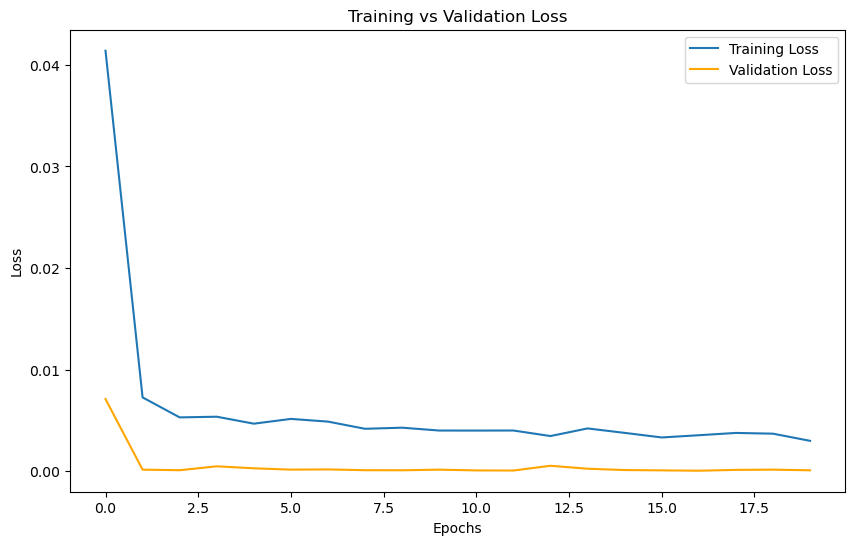

In [27]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
test_loss = model1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

train_loss = model1.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss}")

8/8 [==============================] - 0s 12ms/step - loss: 9.5804e-05
Test Loss: 9.580383630236611e-05
32/32 [==============================] - 0s 13ms/step - loss: 0.0014
Train Loss: 0.0014499521348625422


In [29]:
y_pred = model1.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"LSTM Model RMSE: {rmse}")

8/8 [==============================] - 1s 18ms/step
LSTM Model RMSE: 0.9102702296491567


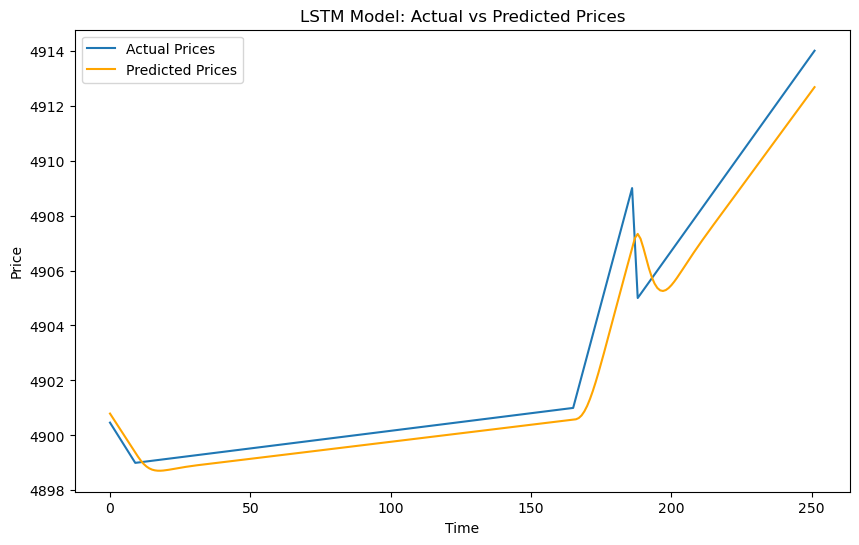

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices', color='orange')
plt.title('LSTM Model: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Forecasting

In [31]:
sequence_length

50

In [32]:
last_sequence = data_scaled[-sequence_length:]  # Use the last `sequence_length` minutes
forecast_sequence = last_sequence.reshape(1, sequence_length, 1)  # Reshape for LSTM input

forecasted_prices = []
for _ in range(60):  # Predict next 10 minutes
    next_price_scaled = model1.predict(forecast_sequence)  # Predict the next price (scaled)
    forecasted_prices.append(next_price_scaled[0, 0])  # Store the predicted value
    next_price_scaled = next_price_scaled.reshape(1, 1, 1)  # Reshape to match LSTM input shape
    forecast_sequence = np.append(forecast_sequence[:, 1:, :], next_price_scaled, axis=1)


1/1 [==============================] - 0s 37ms/step


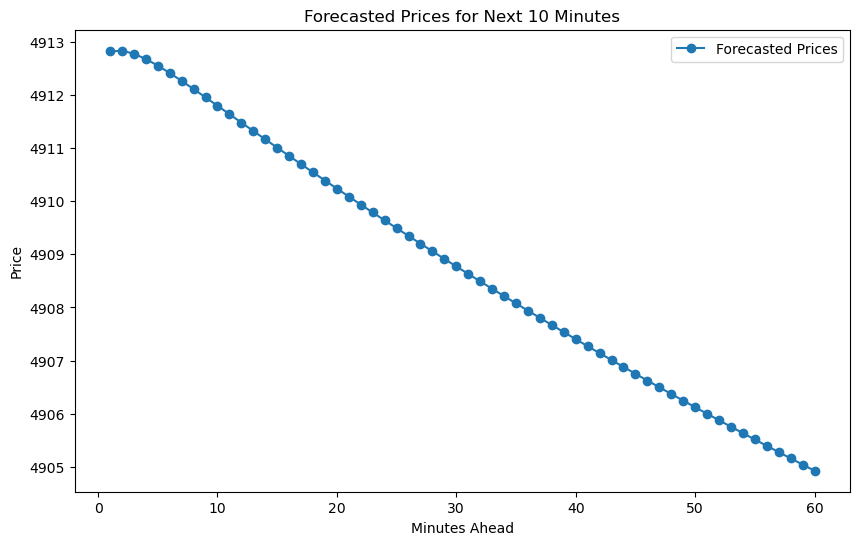

Forecasted Prices for the Next 10 Minutes:
Minute 1: 4912.81
Minute 2: 4912.83
Minute 3: 4912.77
Minute 4: 4912.67
Minute 5: 4912.55
Minute 6: 4912.41
Minute 7: 4912.26
Minute 8: 4912.11
Minute 9: 4911.95
Minute 10: 4911.79
Minute 11: 4911.63
Minute 12: 4911.48
Minute 13: 4911.32
Minute 14: 4911.16
Minute 15: 4911.00
Minute 16: 4910.85
Minute 17: 4910.69
Minute 18: 4910.54
Minute 19: 4910.39
Minute 20: 4910.23
Minute 21: 4910.08
Minute 22: 4909.93
Minute 23: 4909.79
Minute 24: 4909.64
Minute 25: 4909.49
Minute 26: 4909.34
Minute 27: 4909.20
Minute 28: 4909.06
Minute 29: 4908.91
Minute 30: 4908.77
Minute 31: 4908.63
Minute 32: 4908.49
Minute 33: 4908.35
Minute 34: 4908.21
Minute 35: 4908.08
Minute 36: 4907.94
Minute 37: 4907.80
Minute 38: 4907.67
Minute 39: 4907.54
Minute 40: 4907.40
Minute 41: 4907.27
Minute 42: 4907.14
Minute 43: 4907.01
Minute 44: 4906.88
Minute 45: 4906.75
Minute 46: 4906.62
Minute 47: 4906.50
Minute 48: 4906.37
Minute 49: 4906.25
Minute 50: 4906.12
Minute 51: 4906.

In [33]:
forecasted_prices = scaler.inverse_transform(np.array(forecasted_prices).reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 61), forecasted_prices, marker='o', label='Forecasted Prices')
plt.title('Forecasted Prices for Next 10 Minutes')
plt.xlabel('Minutes Ahead')
plt.ylabel('Price')
plt.legend()
plt.show()

print("Forecasted Prices for the Next 10 Minutes:")
for i, price in enumerate(forecasted_prices, 1):
    print(f"Minute {i}: {price[0]:.2f}")


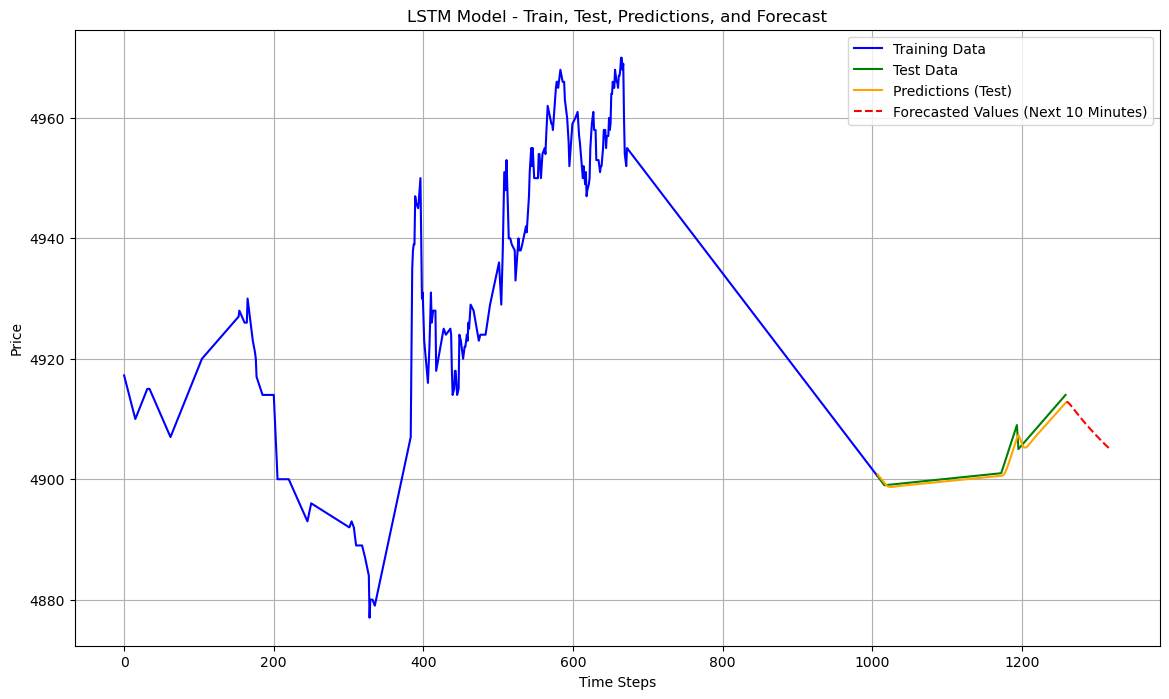

In [34]:
forecast_range = np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60)
plt.figure(figsize=(14, 8))

# Plot the training data
plt.plot(range(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label="Training Data", color='blue')

# Plot the test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label="Test Data", color='green')

# Plot the predictions on the test set
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_rescaled, label="Predictions (Test)", color='orange')

# Plot the forecasted values
plt.plot(forecast_range, forecasted_prices, label="Forecasted Values (Next 10 Minutes)", color='red', linestyle='--')

# Add labels, legend, and title
plt.title("LSTM Model - Train, Test, Predictions, and Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid()

plt.show()


In [36]:
import os
import pickle



if not os.path.exists('models'):
    os.makedirs('models')

with open('models/arima_model.pkl', 'wb') as file:
    pickle.dump(arima_result, file)

with open('models/sarima_model.pkl', 'wb') as file:
    pickle.dump(sarima_result, file)

lstm_model_path = 'models/lstm_model.h5'
model1.save(lstm_model_path) 

c:\Users\arshi\anaconda3\envs\price_forecast\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
